# F1 Japan 2025 Data Analysis Project

### Setup and Data Input

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import os
for dirname, _, filenames in os.walk("./kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))



./kaggle/input/lap_times_2025.csv
./kaggle/input/race_results_2025.csv
./kaggle/input/season_data_2025.csv
./kaggle/input/drivers_2025.csv
./kaggle/input/driver_standings_2025.csv
./kaggle/input/pit_stops_2025.csv
./kaggle/input/constructor_results_2025.csv
./kaggle/input/races_data_2025.csv
./kaggle/input/race_status_2025.csv
./kaggle/input/constructors_2025.csv
./kaggle/input/constructor_standings_2025.csv
./kaggle/input/qualifying_results_2025.csv


### Data Cleaning

In [2]:
lap_times_df = pd.read_csv("./kaggle/input/lap_times_2025.csv")
drivers_df = pd.read_csv("./kaggle/input/drivers_2025.csv")
quali_df = pd.read_csv("./kaggle/input/qualifying_results_2025.csv")


# =======================
# Standardising headers
#========================

print(lap_times_df.columns.to_list())
print(drivers_df.columns.to_list())
print(quali_df.columns.tolist())

lap_times_df.columns = lap_times_df.columns.str.strip().str.lower().str.replace(' ', '_')
drivers_df.columns = drivers_df.columns.str.strip().str.lower().str.replace(' ', '_')
quali_df.columns = quali_df.columns.str.strip().str.lower().str.replace(' ', '_')

print(lap_times_df.columns.to_list())
print(drivers_df.columns.to_list())
print(quali_df.columns.tolist())


race_df = pd.merge(drivers_df, lap_times_df, left_on="abbreviation", right_on="driver", how="outer")

race_df = race_df.drop(['time'], axis=1)

['Driver', 'Lap Number', 'Lap Time', 'Position', 'Time', 'Sector 1', 'Sector 2', 'Sector 3']
['Number', 'Driver ID', 'Abbreviation', 'First Name', 'Last Name', 'Full Name', 'Team']
['Abbreviation', 'Driver ID', 'Full Name', 'Team', 'Q1 Time', 'Q2 Time', 'Q3 Time', 'Position']
['driver', 'lap_number', 'lap_time', 'position', 'time', 'sector_1', 'sector_2', 'sector_3']
['number', 'driver_id', 'abbreviation', 'first_name', 'last_name', 'full_name', 'team']
['abbreviation', 'driver_id', 'full_name', 'team', 'q1_time', 'q2_time', 'q3_time', 'position']


In [3]:


print(race_df["position"].unique())
race_df.dtypes


[10.  7.  9.  4.  5. 13. nan 16. 12. 11.  8. 20. 17. 15. 14.  3.  2.  1.
 19.  6. 18.]


number            int64
driver_id           str
abbreviation        str
first_name          str
last_name           str
full_name           str
team                str
driver              str
lap_number      float64
lap_time            str
position        float64
sector_1            str
sector_2            str
sector_3            str
dtype: object

In [4]:
# =====================================
# Converting time values to seconds
# =====================================

def convert_to_seconds(series: pd.Series) -> pd.Series:
    """ 
    Converts laptimes into seconds format
    
    Args: 
        series: Pandas series containing a string representing laptimes for a race in hours:minutes:seconds
    
    Returns:
        Panadas series containing the lap times in seconds
    
    """
    # Doing it series-wise is much more efficient as pandas is optimised for this
    minutes = series.str.split(":", expand=True)[1].astype(float)
    seconds = series.str.split(":", expand=True)[2].astype(float)

    # This automatically handles NaN values as anything interpreted as not a number by the astype remains like that, and operations on NaN values
    # always return NaN values anyway. No need to handle it manually
    return 60*minutes + seconds

race_df['lap_time'] = convert_to_seconds(race_df["lap_time"])
race_df['sector_1'] = convert_to_seconds(race_df["sector_1"])
race_df['sector_2'] = convert_to_seconds(race_df["sector_2"])
race_df['sector_3'] = convert_to_seconds(race_df["sector_3"])

race_df["lap_number"] = race_df["lap_number"].astype(int)



### Breakdown of aggregated lap times across all drivers, throughout the race

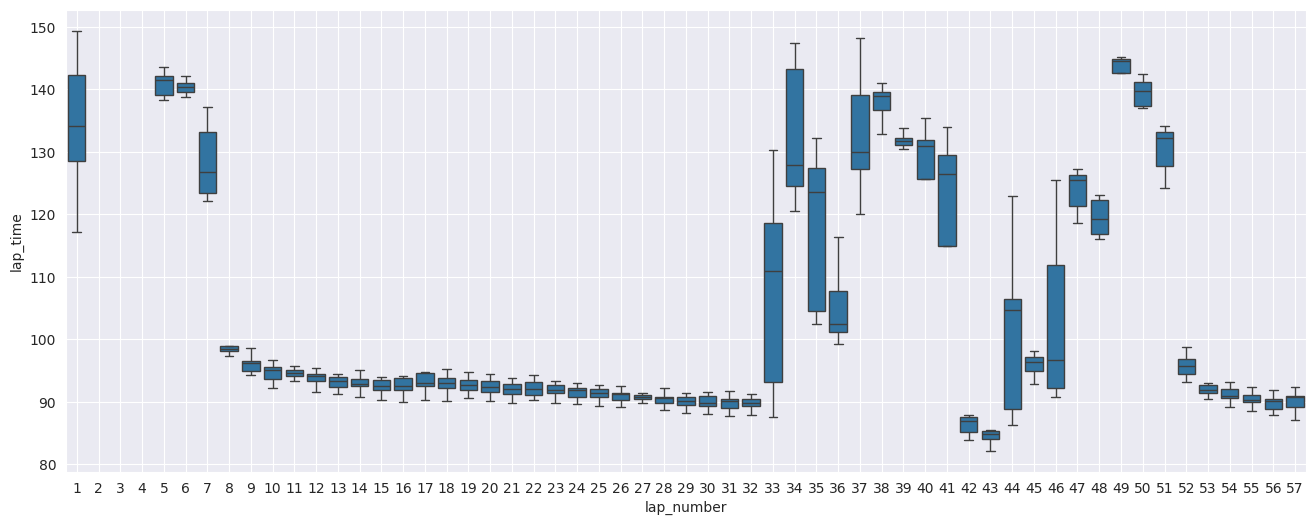

In [5]:
plt.figure(figsize=(16,6))
sns.set_style('darkgrid')
sns.boxplot(data=race_df, x="lap_number", y="lap_time", showfliers=False)
plt.grid(True)
plt.show()

#### Interpretation and notes
This plot shows a box plot of the measures of the dispersion of lap times across each lap of the race, considering all drivers together. The first lap had very high upper and lower bounds, and spread. This is likely due to how much of an impact position has on the initial lap times, as cars near the front get much more opportunity to drive uninhibited by traffic, whereas cars closer to the back will always be significantly slower as they start from further behind, and have more cars around them, forcing them to take suboptimal lines and slow down, or attempt overtakes which often involve making moves which are, in a vaccume, slower over an entire lap compared to the optimal racing line. 
Laps 2 and 3 likely had some kind of incident or interruption to the race that meant the laps were invalidated. Hence the missing values for these laps. But continuing on after this, we see a decline in the spread and total time as the race enters a more stable period. More people are getting clean laps, and cars are more spread out on the track resulting in lap times that more closesly represent times achieveable in optimal conditions. There is a very low dispersion here, within the scale of a few seconds between all drivers, showing how closesly matched the field is. The lap times steadily decrease between 8 and 32, as people settle into a rhythm, and as the car gets lighter with reduced fuel load.
Upon reaching lap 33, we see a large, and varying dispersion in lap times as people begin to take their pit stops for new tyres. 
This variance settles down again once everyone has pitted and the final laps resemble those of before the pit stop period.


### Lap times by driver

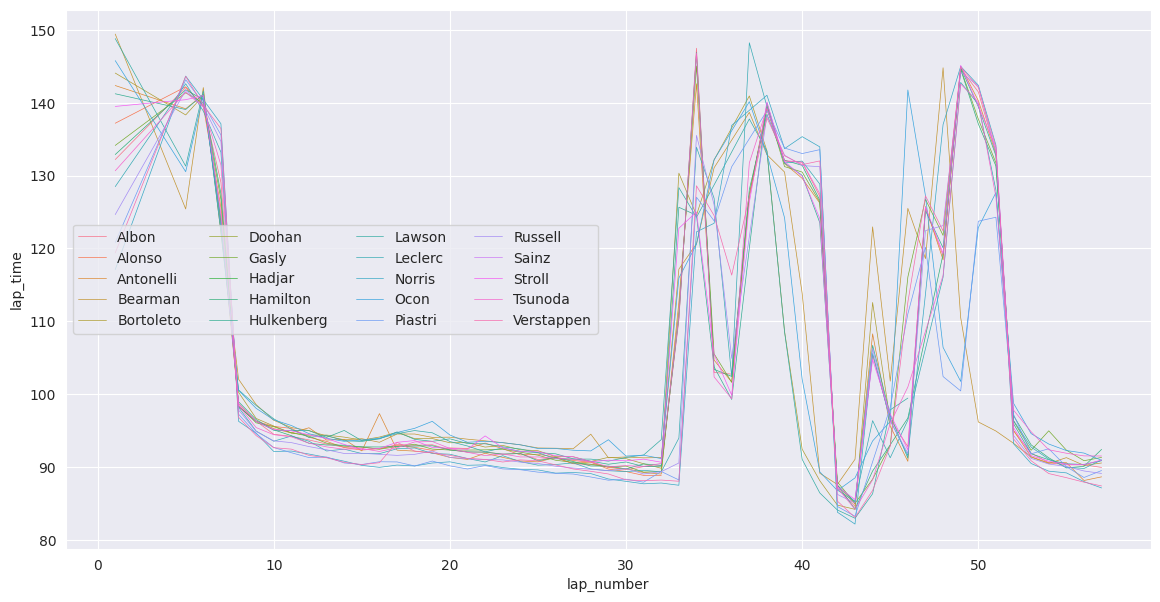

In [6]:
plt.figure(figsize=(14,7))
sns.lineplot(data=race_df[["lap_time", "lap_number","last_name"]], x="lap_number", y="lap_time", hue="last_name", linewidth=0.5)
plt.legend(ncol=4)
plt.show()

#### Interpretations and Notes
This figure show a line chart of the lap times for each driver across the race. There is an overarching general trend that most drivers follow, with more variance in the laps 30-50, where most of the drivers took their pit stops. Reflecting the differences in race strategy and situational decisions for when to pit. In the stable parts of the race, people tended to keep the relative time differences between drivers similar, reflecting overall strength of the drivers even as lap times fall due to reduced fuel weight in the cars.  

### How did each drivers qualifying time compare to their best lap time?

In [8]:
quali_df.dtypes

abbreviation        str
driver_id           str
full_name           str
team                str
q1_time             str
q2_time             str
q3_time             str
position        float64
dtype: object

In [ ]:
# grabbing the fastest lap from the race grouped by driver ID, then turning that into a new dataframe and renaming columns
fastest_laps_df = race_df.groupby("driver_id")["lap_time"].min().reset_index()
fastest_laps_df.rename(columns={"lap_time": "best_laptime_race"}, inplace=True)

#converting quali times to seconds and finding the minimum
#quali_df[["q1_time", "q2_time", "q3_time"]] = quali_df[["q1_time", "q2_time", "q3_time"]].apply(convert_to_seconds)
quali_df["best_laptime_quali"] = quali_df[["q1_time", "q2_time","q3_time"]].min(axis=1) # axis=1 makes this min search go along the row, not down the column

# Merging the two dataframes based on driver ID
quali_race_comparison_df = pd.merge(fastest_laps_df, quali_df, on="driver_id")
quali_race_comparison_df.head()

# make the df in long format, required for seaborn to create a plot based on a set of variables we can use as x and y
# Basically transforms the dataframe to have a single row lap or quali time to putting quali and race times in a single column variable, with a label for session
quali_race_long = pd.melt(
    quali_race_comparison_df,
    id_vars=["driver_id"],
    value_vars=["best_laptime_quali", "best_laptime_race"],
    var_name="session",
    value_name="time"
)
plt.figure(figsize=(14,6))
sns.lineplot(data=quali_race_long, x="session", y="time", hue="driver_id", linewidth=0.7)
plt.legend(ncol=4)
plt.show()


#### Interpretations and Notes
This plot shows a driver's best race laptime versus there best qualifying time. A steeper angle means that a driver was less able to produce a quality lap in the race compared to their qualifying. Shallower line means their best in-race laptime was closer to their qualfying time. This might have some indication for a driver's ability to handle the stresses and unpredictability of real-race conditions to extract their best performance from a race. Race laptimes will almost always be higher than qualifying times, since during qualifying they will only take a very low fuel load and have tyres that are in much better condition than typically found in the race. Differences could also reflect changes in track conditions, if weather got worse between qualifying and the race. 

### How does each sector contribute to total laptime?



In [ ]:
valid_laps_df = race_df.dropna(subset=['lap_time'])
idx = valid_laps_df.groupby("driver_id")["lap_time"].idxmin()
fastest_laps_df_2 = valid_laps_df.loc[idx].reset_index(drop=True)
fastest_laps_df_2.head()

sector_df_long = pd.melt(
    fastest_laps_df_2,
    id_vars=['driver_id'],
    value_vars=['sector_1','sector_2','sector_3'],
    var_name='sector',
    value_name='time'
)
sector_df_long.head()


fig = px.bar(sector_df_long, x='driver_id', y='time', color='sector', height=600)
fig.show()